In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import json
from itertools import chain, product
from collections import defaultdict
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, BRICS
from krxns.cheminfo import expand_unpaired_cofactors, MorganFingerPrinter, tanimoto_similarity, mcs
from krxns.config import data_filepath, sim_mats_filepath, cofactors_filepath, brics_sim_mats_filepath
import ipywidgets as widgets
from ipywidgets import interact
print(rdkit.__version__)

2024.03.2


In [2]:
# Load known reaction data
with open(data_filepath / "sprhea_240310_v3_mapped.json", 'r') as f:
    known_reactions = json.load(f)

known_reactions = {int(k): v for k,v in known_reactions.items()}

# Extract known compounds
known_compounds = {}
for elt in known_reactions.values():
    subs = chain(*[side.split(".") for side in elt['smarts'].split(">>")])
    for sub in subs:
        known_compounds[sub] = elt['smi2name'].get(sub, None)

known_compounds = {i: {'smiles': k, 'name': v} for i, (k, v) in enumerate(known_compounds.items())}
smi2id = {v['smiles']: k for k,v in known_compounds.items()}

# Remove reverses
rids = set()
for k, v in known_reactions.items():
    rids.add(tuple(sorted([k, v['reverse']])))

keepers = [elt[0] for elt in rids]

known_reactions = {k: known_reactions[k] for k in keepers}
print(len(known_reactions))

9801


In [84]:
# Load cofactors

k = 10

paired_fp = cofactors_filepath / "paired_cofactors_reference.tsv"
unpaired_fp = cofactors_filepath / "unpaired_cofactors_reference.tsv"
name_blacklist = [
    'acetyl-CoA',
    'CoA'
]

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

filtered_unpaired = unpaired_ref.loc[~unpaired_ref['Name'].isin(name_blacklist), :]

cofactors = expand_unpaired_cofactors(filtered_unpaired, k=k)

manual = {
    '[Fe+2]': 'Fe2+',
    '[Fe+3]': 'Fe3+'
}

cofactors = {**cofactors, ** manual}

[17:10:08] WARNING: not removing hydrogen atom without neighbors


In [4]:
# Create graph

G = nx.MultiGraph()

G.add_nodes_from([(k, v) for k,v in known_compounds.items()])

for rid, rxn in known_reactions.items():
    lhs, rhs = [side.split(".") for side in rxn['smarts'].split(">>")]
    for pair in product(lhs, rhs):
        left_cid, right_cid = smi2id[pair[0]], smi2id[pair[1]]
        G.add_edge(left_cid, right_cid, **rxn)


In [5]:
G.number_of_nodes(), G.number_of_edges()

(8777, 92260)

Demonstrate the problem with naively connecting all substrates that appear opposite one another in a reaction

In [6]:
[elt for elt in known_compounds.values() if elt['name'] == "NADH"]
smi2id['NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1']
nadh_neighbors = list(G.neighbors(71))
[G.nodes[elt] for elt in nadh_neighbors]

[{'smiles': 'Nc1ccn(C2OC(COP(=O)(O)O)C(O)C2O)c(=O)n1', 'name': 'CMP'},
 {'smiles': '*NC(COP(=O)(O)OCC[N+](C)(C)C)C(*)=O',
  'name': 'O-phosphocholine-L-serine residue'},
 {'smiles': 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O', 'name': 'ADP'},
 {'smiles': '*NC(COP(=O)(O)O)C(*)=O', 'name': 'O-phospho-L-serine residue'},
 {'smiles': 'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS',
  'name': 'CoA'},
 {'smiles': '*NC(COC(=O)CCCCCCC)C(*)=O',
  'name': 'O-octanoyl-L-serine residue'},
 {'smiles': '*NC(COC1OC(COP(=O)(O)OP(=O)(O)OCC2OC(n3cnc4c(N)ncnc43)C(O)C2O)C(O)C1O)C(*)=O',
  'name': 'O-(ADP-D-ribosyl)-L-serine residue'},
 {'smiles': 'NC(=O)c1cccnc1', 'name': 'nicotinamide'},
 {'smiles': '*NC(COC(=O)CCCCCCCCCCCCC)C(*)=O',
  'name': 'O-tetradecanoyl-L-serine residue'},
 {'smiles': '*NC(COC(=O)CCC)C(*)=O', 'name': 'O-butanoyl-L-serine residue'},
 {'smiles': 'O=P(O)(O)OP(=O)(O)O', 'name': 'diphosphate'},
 {'smiles': '*NC(COP(=O)(O)OCC1OC(n2ccc(=O)[

In [7]:
name = 'pyruvate'
pyruvate_idxs = [x for x,y in G.nodes(data=True) if y['name'] == 'pyruvate']
succinate_idxs = [x for x,y in G.nodes(data=True) if y['name'] == 'succinate']
G.nodes[pyruvate_idxs[0]], G.nodes[succinate_idxs[0]]

({'smiles': 'CC(=O)C(=O)O', 'name': 'pyruvate'},
 {'smiles': 'O=C(O)CCC(=O)O', 'name': 'succinate'})

In [8]:
path = nx.shortest_path(G, source=pyruvate_idxs[0], target=succinate_idxs[0])
path_rxns = []
for id in path:
    print(G.nodes[id])

for i in range(len(path) - 1):
    s = path[i]
    t = path[i + 1]
    # btwn = [elt for elt in G.edges if elt[0] == s and elt[1] == t]
    path_rxns.append(G.edges[(s, t, 0)]['smarts'])

{'smiles': 'CC(=O)C(=O)O', 'name': 'pyruvate'}
{'smiles': 'O=C(O)CCC(=O)C(=O)O', 'name': '2-oxoglutarate'}
{'smiles': 'O=C(O)CCC(=O)O', 'name': 'succinate'}


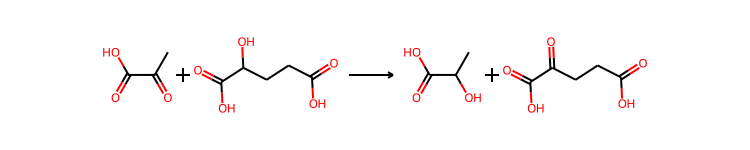

In [9]:
AllChem.ReactionFromSmarts(path_rxns[0], useSmiles=True)

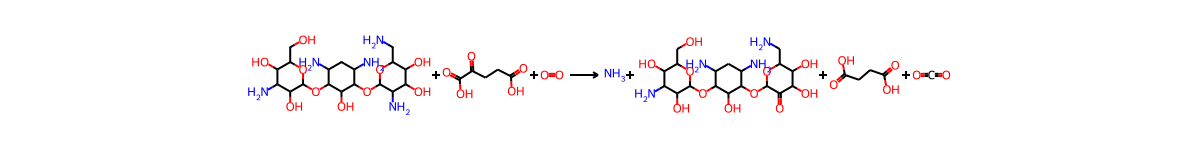

In [10]:
AllChem.ReactionFromSmarts(path_rxns[1], useSmiles=True)

Look at "frustration" in reactant product alignment

In [85]:
# Construct sim mats based on correlated appearance in reactions or structure

cpd_corr = np.zeros(shape=(len(known_compounds), len(known_compounds)))
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    for pair in product(lhs, rhs):
        i, j = [smi2id[elt] for elt in pair]
        cpd_corr[i, j] += 1
        cpd_corr[j, i] += 1
    
row_sum = cpd_corr.sum(axis=1).reshape(-1, 1)
col_sum = cpd_corr.sum(axis=0).reshape(1, -1)
cpd_jaccard = cpd_corr / (row_sum + col_sum - cpd_corr) # Jaccard co-occurence-in-rxn index. Symmetric
cond_prob = cpd_corr / row_sum # elt (i, j) gives P(cpd_j | cpd_i). NOT symmetric

cpd_tani = np.load(sim_mats_filepath / "tanimoto.npy")
cpd_mcs = np.load(sim_mats_filepath / "mcs.npy")
brics_mats = {}
for fn in brics_sim_mats_filepath.iterdir():
    rid = int(fn.stem)
    df = pd.read_csv(fn, sep='\t', index_col=0)
    brics_mats[rid] = df

cc_sim_mats = {
    'mcs': cpd_mcs,
    'tanimoto': cpd_tani,
    'jaccard': cpd_jaccard,
}

sim_mat_names = list(cc_sim_mats.keys()) + ['brics']

In [87]:
rxn_sim_mats = defaultdict(dict)
id_rsms = defaultdict(dict)
side_counts = defaultdict(set)
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = sorted([elt for elt in lhs if elt not in cofactors])
    rhs = sorted([elt for elt in rhs if elt not in cofactors])

    if not lhs or not rhs:
        continue

    if len(lhs) > len(rhs):
        tmp = lhs
        lhs = rhs
        rhs = tmp

    left_ids, right_ids = np.array([smi2id[smi] for smi in lhs]), np.array([smi2id[smi] for smi in rhs])
    left_names, right_names = [known_compounds[id]['name'] for id in left_ids], [known_compounds[id]['name'] for id in right_ids]


    # Add cpd sim mats
    i, j = np.array(list(zip(*product(left_ids, right_ids))))
    for k, cs in cc_sim_mats.items():
        data = cs[i, j].reshape(len(left_ids), len(right_ids))
        
        df = pd.DataFrame(data=data, columns=right_names, index=left_names)
        rxn_sim_mats[rid][k] = df

        df = pd.DataFrame(data=data, columns=right_ids, index=left_ids)
        id_rsms[rid][k] = df

    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)


In [ ]:
sorted([(k, len(v)) for k,v in side_counts.items()], key= lambda x : x[1], reverse=True)

[((2, 2), 5455),
 ((1, 1), 1758),
 ((1, 2), 1738),
 ((2, 3), 612),
 ((3, 3), 127),
 ((3, 4), 34),
 ((4, 4), 16),
 ((1, 3), 12),
 ((3, 5), 12),
 ((2, 4), 9),
 ((4, 5), 4),
 ((5, 6), 3),
 ((4, 6), 3),
 ((2, 5), 2),
 ((5, 5), 2),
 ((5, 7), 1),
 ((3, 6), 1)]

In [88]:
from scipy.stats import entropy
def connect_reaction(rsms: dict[str, pd.DataFrame]):
    def get_partner(sim, candidates):
        # print(sim.shape)
        sim /= sim.sum(axis=0).reshape(1, -1)
        H = entropy(sim, axis=0).reshape(-1,)
        midx = np.argmin(H)
        return candidates[np.argmax(sim[:, midx])]

    tmp_lid = set()
    tmp_rid = set()
    sim_block = []
    n_metrics = 0
    for k, v in rsms.items():
        tmp_lid.add(tuple(v.index))
        tmp_rid.add(tuple(v.columns))
        sim_block.append(v.to_numpy())
        n_metrics += 1

    if len(tmp_lid) > 1 or len(tmp_rid) > 1:
        raise ValueError("IDs from similarity matrices are not the same")
    else:
        lid = list(tmp_lid)[0]
        rid = list(tmp_rid)[0]
        sim_block = np.stack(sim_block, axis=-1)

    l_partners = {}
    for i, li in enumerate(lid):
        sim = sim_block[i, :, :].copy().reshape(-1, n_metrics)
        # print(sim.shape)
        l_partners[li] = get_partner(sim, rid)

    r_partners = {}
    for j, rj in enumerate(rid):
        sim = sim_block[:, j, :].copy().reshape(-1, n_metrics)
        # print(sim.shape)
        r_partners[rj] = get_partner(sim, lid)

    adj_mat = pd.DataFrame(
        data=np.zeros(shape=(len(lid), len(rid))),
        index=lid,
        columns=rid
    )
    
    for li, p in l_partners.items():
        adj_mat.loc[li, p] = 1

    for rj, p in r_partners.items():
        adj_mat.loc[p, rj] = 1

    return {"left": l_partners, "right": r_partners, "adj_mat": adj_mat}

res = connect_reaction(id_rsms[0])
display(res['adj_mat'])
print(res)


,4,3
1,1.0,0.0
0,0.0,1.0


{'left': {1: 4, 0: 3}, 'right': {4: 1, 3: 0}, 'adj_mat':      4    3
1  1.0  0.0
0  0.0  1.0}


In [89]:
rxn_cxn = {}
for rid, rsm in id_rsms.items():
    # print(rid)
    rxn_cxn[rid] = connect_reaction(rsm)

/tmp/ipykernel_576738/2557401246.py:5: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)


In [90]:
def is_frustrated(rxn_sim_mat: pd.DataFrame):
    rxn_sim_mat = rxn_sim_mat.to_numpy()

    if rxn_sim_mat.shape[0] > rxn_sim_mat.shape[1]:
        rxn_sim_mat = rxn_sim_mat.T

    m, n = rxn_sim_mat.shape
    rct_partners = np.argmax(rxn_sim_mat, axis=1)
    pdt_partners = np.argmax(rxn_sim_mat, axis=0)
    partner_matches = [pdt_partners[rct_partners[i]] == i for i in range(len(rct_partners))]

    if sum(partner_matches) == m:
        return False
    else:
        return True

In [91]:
frustrated = set()
for rid, entry in rxn_cxn.items():

    if is_frustrated(entry['adj_mat']):
        frustrated.add(rid)

len(frustrated)

749

In [93]:
options = sorted(frustrated)
frustrated_rids = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

@interact
def display_rxn_info(rid=frustrated_rids):
    sis = (300, 200) # sub img size
    for k in cc_sim_mats:
        display(rxn_sim_mats[rid][k])

    adj = rxn_cxn[rid]['adj_mat'].copy()
    adj.columns = [known_compounds[elt]['name'] for elt in adj.columns]
    adj.index = [known_compounds[elt]['name'] for elt in adj.index]
    display(adj)

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), known_compounds[smi2id[smi]]['name'])
            for smi in known_reactions[rid]['smi2name'] if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

interactive(children=(Dropdown(description='Rxn ID:', options=(2, 24, 40, 42, 98, 110, 155, 165, 182, 184, 187…

In [94]:
options = sorted([rid for rid in rxn_cxn if rid not in frustrated])
not_frustrated_rids = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

@interact
def display_rxn_info(rid=not_frustrated_rids):
    sis = (300, 200) # sub img size
    for k in cc_sim_mats:
        display(rxn_sim_mats[rid][k])

    adj = rxn_cxn[rid]['adj_mat'].copy()
    adj.columns = [known_compounds[elt]['name'] for elt in adj.columns]
    adj.index = [known_compounds[elt]['name'] for elt in adj.index]
    display(adj)

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), known_compounds[smi2id[smi]]['name'])
            for smi in known_reactions[rid]['smi2name'] if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

interactive(children=(Dropdown(description='Rxn ID:', options=(0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16,…

In [16]:
# How many equal reactant-product counts are frustrated?



frustrated = defaultdict(set)
for rid, metrics in rxn_sim_mats.items():
    for m, rsm in metrics.items():

        if is_frustrated(rsm):
            frustrated[m].add(rid)

In [17]:
for k,v in frustrated.items():
    print(f"{k}: {len(v)} / {len(rxn_sim_mats)}")

any_frustrated = set(frustrated['mcs']) | set(frustrated['jaccard']) | set(frustrated['tanimoto'])

print(f"Any metric frustrated / total rxns: {len(any_frustrated)} / {len(rxn_sim_mats)}")

print(f"{len(set(frustrated['mcs']) ^ set(frustrated['jaccard']))} / {len(set(frustrated['mcs']) | set(frustrated['jaccard']))}")

brics: 2993 / 9789
mcs: 681 / 9789
tanimoto: 1011 / 9789
jaccard: 728 / 9789
Any metric frustrated / total rxns: 1700 / 9789
1113 / 1261


In [18]:
rxn_sim_mats[740]['jaccard']

,O-[S-(4Z)-hexadecenoylpantetheine-4'-phosphoryl]serine residue,Fe(3+)
O-(S-hexadecanoylpantetheine-4'-phosphoryl)-L-serine residue,0.024390,0.002125
Fe(2+),0.001032,0.200899


In [19]:
options = sorted(any_frustrated)
frustrated_rids = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

@interact
def display_rxn_info(rid=frustrated_rids):
    sis = (300, 200) # sub img size
    for k in sim_mat_names:
        print(f"{k.upper()} frustrated: {rid in frustrated[k]}")
        display(rxn_sim_mats[rid][k])

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), name)
            for smi, name in known_reactions[rid]['smi2name'].items() if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

interactive(children=(Dropdown(description='Rxn ID:', options=(2, 24, 38, 40, 42, 43, 44, 47, 54, 69, 89, 94, …

In [20]:
options = sorted(set(rxn_sim_mats) - any_frustrated)
unfrustrated_rids = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

@interact
def display_rxn_info(rid=unfrustrated_rids):
    sis = (300, 200) # sub img size
    for k in sim_mat_names:
        print(f"{k.upper()} frustrated: {rid in frustrated[k]}")
        display(rxn_sim_mats[rid][k])

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), name)
            for smi, name in known_reactions[rid]['smi2name'].items() if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

interactive(children=(Dropdown(description='Rxn ID:', options=(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, …

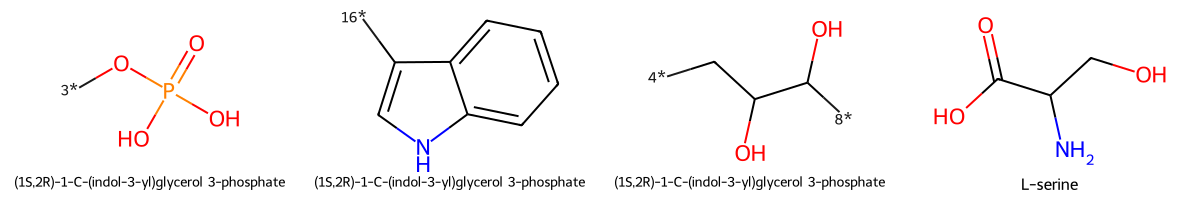

-------------------------------------------------->


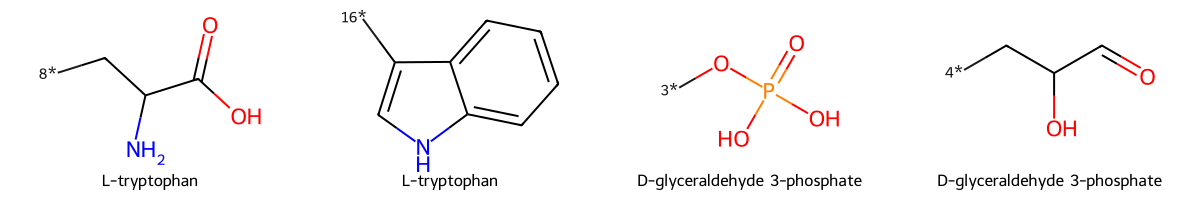

In [21]:
rid = 110
sis = (300, 200)
split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]
for i, side in enumerate(split_subs):
    frags = []
    frag_names = []
    for smi in side:
        if smi in cofactors:
            continue

        name = known_reactions[rid]['smi2name'][smi]
        mol = Chem.MolFromSmiles(smi)
        new_frags = [Chem.MolFromSmiles(elt) for elt in BRICS.BRICSDecompose(mol)]
        frags += new_frags
        frag_names += [name for _ in range(len(new_frags))]
    
    display(Draw.MolsToGridImage(frags, molsPerRow=len(frags), legends=frag_names, subImgSize=sis))

    if i == 0:
        print(f"{'-' * 50}>")

CoAs always come in pairs unless they are being synthesized

In [22]:
# CoA reactions study

coa_rxns = {}
for k, v in known_reactions.items():
    for name in v['smi2name'].values():
        if name is None:
            continue

        if 'CoA' in name:
            coa_rxns[k] = v
            break


unpaired_coa_rxns = {}
for k, v in coa_rxns.items():
    lhs_coa, rhs_coa = False, False
    rcts, pdts = [elt.split(".") for elt in v['smarts'].split(">>")]
    lhs_coa = any(['CoA' in  v['smi2name'][smi] for smi in rcts if v['smi2name'][smi] is not None])
    rhs_coa = any(['CoA' in  v['smi2name'][smi] for smi in pdts if v['smi2name'][smi] is not None])

    if lhs_coa ^ rhs_coa:
        unpaired_coa_rxns[k] = v

# for k, v in unpaired_coa_rxns.items():
#     rcts, pdts = [elt.split(".") for elt in v['smarts'].split(">>")]
#     rnames = [v['smi2name'][smi] for smi in rcts if v['smi2name'][smi] is not None]
#     pnames = [v['smi2name'][smi] for smi in pdts if v['smi2name'][smi] is not None]
#     print(f"{' + '.join(rnames)} --> {' + '.join(pnames)}")

In [23]:
len(coa_rxns), len(unpaired_coa_rxns)

(1533, 27)

{'*OC1C(COP(*)(=O)O)OC(c2c[nH]c(=O)[nH]c2=O)C1O': 'psi-uridine residue', 'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O': 'S-adenosyl-L-methionine', '*OC1C(COP(*)(=O)O)OC(c2c[nH]c(=O)n(C)c2=O)C1O': "N(3)-methylpseudouridine 5'-phosphate residue", 'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O': 'S-adenosyl-L-homocysteine'}
0.6666667


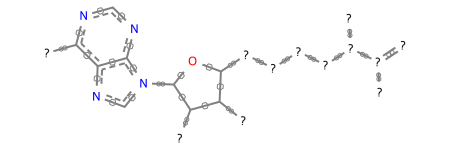

In [24]:
#SAM mcs corner case

print(known_reactions[19]['smi2name'])
smis = [
    'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
    'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O'
]

mols = [Chem.MolFromSmiles(smi) for smi in smis]
print(mcs(mols))

from rdkit.Chem import rdFMCS

res = rdFMCS.FindMCS(
        mols,
        atomCompare=rdFMCS.AtomCompare.CompareElements,
        bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        matchChiralTag=False,
        ringMatchesRingOnly=True,
        completeRingsOnly=False,
        matchValences=False,
        timeout=10
    )
Chem.MolFromSmarts(res.smartsString)

In [25]:
foo = [1,1,2,3,4,4]
bar = set(foo)
baz = set(foo)
bar, baz

({1, 2, 3, 4}, {1, 2, 3, 4})